In [1]:
# basic
import pandas as pd
import numpy as np
import ast
import json
import os

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#pearson
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
# convert string to dictionary
def to_dict(attribute):
    try:
        if attribute != None:
            return ast.literal_eval(attribute)
        else:
            return ast.literal_eval("{}")
    except Exception as ex:
        print(ex)

In [3]:
# importing restaurants
restaurant = pd.read_csv('sample_restaurant.csv')

In [4]:
# expand out attributes and make them their own columns
restaurant['attributes'] = restaurant['attributes'].replace(r'^\s*$', np.nan, regex=True)
restaurant['attributes'] = restaurant['attributes'].where(pd.notnull(restaurant['attributes']), None)
attributes_dict = [to_dict(x) for x in restaurant['attributes']]
attributes = pd.DataFrame(attributes_dict)

pd.set_option('display.max_columns', None)

In [5]:
# expand out nested dictionaries like GoodForMeal and Ambience
attributes['GoodForMeal'] = attributes['GoodForMeal'].where(pd.notnull(attributes['GoodForMeal']), None)
gfm_dict = [to_dict(x) for x in attributes['GoodForMeal']]
gfm = pd.json_normalize(gfm_dict)
# print(gfm)

attributes['Ambience'] = attributes['Ambience'].where(pd.notnull(attributes['Ambience']), None)
a_dict = [to_dict(x) for x in attributes['Ambience']]
a = pd.json_normalize(a_dict)
# print(a)

attributes['BusinessParking'] = attributes['BusinessParking'].where(pd.notnull(attributes['BusinessParking']), None)
bp_dict = [to_dict(x) for x in attributes['BusinessParking']]
bp = pd.json_normalize(bp_dict)
# print(bp)

attributes['BestNights'] = attributes['BestNights'].where(pd.notnull(attributes['BestNights']), None)
bn_dict = [to_dict(x) for x in attributes['BestNights']]
bn = pd.json_normalize(bn_dict)
bn = bn.rename(columns={'monday': 'monday_bn', 'tuesday': 'tuesday_bn', 
                        'wednesday': 'wednesday_bn', 'thursday': 'thursday_bn', 
                        'friday': 'friday_bn', 'saturday': 'saturday_bn', 'sunday': 'sunday_bn'})
# print(bn)

attributes['Music'] = attributes['Music'].where(pd.notnull(attributes['Music']), None)
m_dict = [to_dict(x) for x in attributes['Music']]
m = pd.json_normalize(m_dict)
# print(m)

attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].where(pd.notnull(attributes['DietaryRestrictions']), None)
dr_dict = [to_dict(x) for x in attributes['DietaryRestrictions']]
dr = pd.json_normalize(dr_dict)
# print(dr)

# drop col in attributes
attributes = attributes.drop(['GoodForMeal', 'Ambience', 'BusinessParking', 'BestNights', 'Music', 'DietaryRestrictions'], 
                             axis=1)

# fuse together
attributes = pd.concat([attributes, gfm, a, bp, bn, m, dr], axis=1)

attributes

,BikeParking,OutdoorSeating,RestaurantsPriceRange2,WiFi,RestaurantsTakeOut,RestaurantsReservations,Alcohol,BusinessAcceptsCreditCards,HappyHour,RestaurantsTableService,HasTV,Caters,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,RestaurantsDelivery,DogsAllowed,GoodForKids,RestaurantsGoodForGroups,RestaurantsAttire,NoiseLevel,DriveThru,BYOBCorkage,Smoking,GoodForDancing,CoatCheck,ByAppointmentOnly,AgesAllowed,Open24Hours,RestaurantsCounterService,AcceptsInsurance,HairSpecializesIn,dessert,latenight,lunch,dinner,brunch,breakfast,touristy,hipster,romantic,intimate,trendy,upscale,classy,casual,divey,garage,street,validated,lot,valet,monday_bn,tuesday_bn,wednesday_bn,thursday_bn,friday_bn,saturday_bn,sunday_bn,dj,background_music,no_music,jukebox,live,video,karaoke,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
0,True,False,2,u'free',True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,False,NaN,u'free',True,True,u'full_bar',True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,NaN,u'free',True,NaN,u'full_bar',True,True,True,True,True,False,False,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,True,None,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,True,1,NaN,True,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,True,True,'casual',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,True,1,'free',True,False,'none',True,False,False,True,False,NaN,NaN,NaN,True,True,True,True,True,'casual',u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,False,True,3,u'no',None,True,u'full_bar',True,NaN,NaN,True,False,NaN,NaN,NaN,NaN,None,False,False,True,'dressy',u'average',None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,False,False,2,u'free',True,True,u'full_bar',True,False,True,True,False,NaN,NaN,False,True,False,False,True,True,u'casual',u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,False,False,True,False,False,False,False,None,None,False,None,None,True,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,True,True,2,u'free',True,True,u'full_bar',NaN,True,True,False,False,False,True,NaN,True,True,True,False,False,u'casual',u'average',NaN,NaN,u'no',False,False,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,NaN,False,True,False,False,False,False,False,False,False,False,True,False,False,Fa

In [6]:
# one hot encode attributes
df = pd.get_dummies(attributes)

counts = {}
for col in df:
    counts[col] = df[col].sum()
    
# sort
counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
# print(counts)

# drop any col with sum < 10000
for col in df:
    if df[col].sum() < 10000:
        df.drop(col, axis=1, inplace=True)

attributes = df
attributes

,BikeParking_True,OutdoorSeating_False,OutdoorSeating_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,WiFi_u'free',RestaurantsTakeOut_True,RestaurantsReservations_False,RestaurantsReservations_True,Alcohol_u'none',BusinessAcceptsCreditCards_True,HasTV_True,Caters_False,Caters_True,RestaurantsDelivery_False,RestaurantsDelivery_True,GoodForKids_True,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',NoiseLevel_u'average',dessert_False,latenight_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,touristy_False,hipster_False,romantic_False,intimate_False,trendy_False,upscale_False,classy_False,casual_False,casual_True,divey_False,garage_False,street_False,validated_False,lot_False,lot_True,valet_False
0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1
1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
2,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1
3,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0
4,1,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0
39996,0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,1,1
39997,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,1
39998,0,1,0,1,0,0,1,1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1


In [7]:
# expand out categories and make them their own columns
# categories = pd.Series(restaurant['categories']).str.get_dummies(',')
# # drop columns that only contain zeros or 1
# categories = categories.loc[:, (categories != 0).any(axis=0)]
# categories

# expand out categories and make them their own columns
categories = pd.Series(restaurant['categories']).str.get_dummies(', ')

def toList(cat):
    return [x.strip() for x in cat.split(',')]

def toSeries(series):
    return pd.Series(x for _list in series for x in _list)

# categories
resCategories = restaurant['categories']
#categories
resCategories = resCategories.apply(toList)
resCategories = toSeries(resCategories)

cat = {}
for _, val in resCategories.items():
    if val in cat:
        cat[val] +=1
    else:
        cat.update({val:1})
        
cat = dict(sorted(cat.items(), key=lambda item: item[1]))

res = {key : val for key, val in cat.items() if not (isinstance(val, int) and (val < 1000))}

catKeys = list(res.keys())
catKeys.remove('Restaurants')
catKeys

categories = categories[catKeys]
categories

,Cocktail Bars,Pubs,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Event Planning & Services,Salad,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
39997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
39998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# fuse into one whole table and drop attributes, categories
restaurant = restaurant.drop(["attributes", "categories", "hours"], axis=1)
restaurant = pd.concat([restaurant, attributes, categories], axis=1)
restaurant

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BikeParking_True,OutdoorSeating_False,OutdoorSeating_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,WiFi_u'free',RestaurantsTakeOut_True,RestaurantsReservations_False,RestaurantsReservations_True,Alcohol_u'none',BusinessAcceptsCreditCards_True,HasTV_True,Caters_False,Caters_True,RestaurantsDelivery_False,RestaurantsDelivery_True,GoodForKids_True,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',NoiseLevel_u'average',dessert_False,latenight_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,touristy_False,hipster_False,romantic_False,intimate_False,trendy_False,upscale_False,classy_False,casual_False,casual_True,divey_False,garage_False,street_False,validated_False,lot_False,lot_True,valet_False,Cocktail Bars,Pubs,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Event Planning & Services,Salad,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,126141,9XotjNYdPzWCokrVMRo4Mg,The Great Canadian Bagel,"120 Wye Road, Unit 101",Sherwood Park,AB,T8A 6P2,53.512479,-113.327738,4.0,9,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,8518,Y92Nc9GhuXWvIABqNtSWGA,Tavern 52,329 Kennett Pike,Mendenhall,PA,19357,39.853403,-75.640789,3.5,21,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2,11669,b5byt9ewnM1U57ygWTTV2g,Crab Du Jour - Delran,4000 US-130,Delran,NJ,08075,40.011577,-74.961777,3.0,25,1,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,116916,4jICs7no7322VjY4hqHVAg,La Cocinita Cubana,113 Central Dr,Brandon,FL,33510,27.939235,-82.292208,4.5,33,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,66207,pWDE_rueENu_f5HKA_AsWw,Dune Coffee Roasters - Storke,250 A Storke Rd,Goleta,CA,93117,34.429540,-119.869271,4.0,159,1,1,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,141107,guwb1zuNEMtJVproo0ntFw,La Boca,870 Tchoupitoulas St,New Orleans,LA,70130,29.943455,-90.067341,4.0,420,1,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39996,66695,-78Va3llKcPbL6SW4is8lw,Mungo's Italian Eatery,100 East Main St,Collinsville,IL,62234,38.669906,-89.985827,4.0,124,1,0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
39997,101198,2pj5byDMoMDu-d0bTu2Sew,Pip,10403 83 Ave NW,Edmonton,AB,T6E 2C7,53.518958,-113.497891,4.0,117,1,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
39998,124342,RKRy17pwMJAbehSkZglwjw,Jia's Wok,477 E Plumb Ln,Reno,NV,89502,39.506363,-119.797213,3.0,35,1,0,1,0,1,0,0,1,1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [9]:
# creating x
x = restaurant.loc[:, 'review_count':]
# can change to whatever amount we consider as "good"
y = restaurant['stars'].apply(lambda x: 1 if x>=4 else 0)

# split!
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

trainColumns = xTrain.columns

# normalize
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

In [10]:
# classifiers
n_cpu = os.cpu_count()

In [11]:
#finding best SVM features
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [13]:
#NB: 
clf = GaussianNB()
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print("f1: ", f1_score(yTest, yPred))
print("accuracy: ", accuracy_score(yTest, yPred))
print("precision: ", precision_score(yTest, yPred))
print("recall: ", recall_score(yTest, yPred))

f1:  0.5848375451263538
accuracy:  0.6454166666666666
precision:  0.604233870967742
recall:  0.5666477595008508


In [ ]:
#SVM:
# clf = SVC()

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'poly', 'sigmoid']}

# grid = GridSearchCV(clf, param_grid, refit=True, verbose=3, cv=3)
# grid.fit(xTrain, yTrain)
# print(grid.best_params_)
# print(grid.best_estimator_)
# grid_predictions = grid.predict(xTest)
# print(classification_report(yTest, grid_predictions))

# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print(classification_report(yTest, yPred))

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)


              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6577
           1       0.70      0.64      0.67      5423

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000

review_count                0.130425
Fast Food                   0.031682
HasTV_True                  0.019753
is_open                     0.019680
RestaurantsDelivery_True    0.019017
BikeParking_True            0.018313
street_False                0.017892
WiFi_u'free'                0.017858
NoiseLevel_u'average'       0.017757
Food                        0.017505
dtype: float64


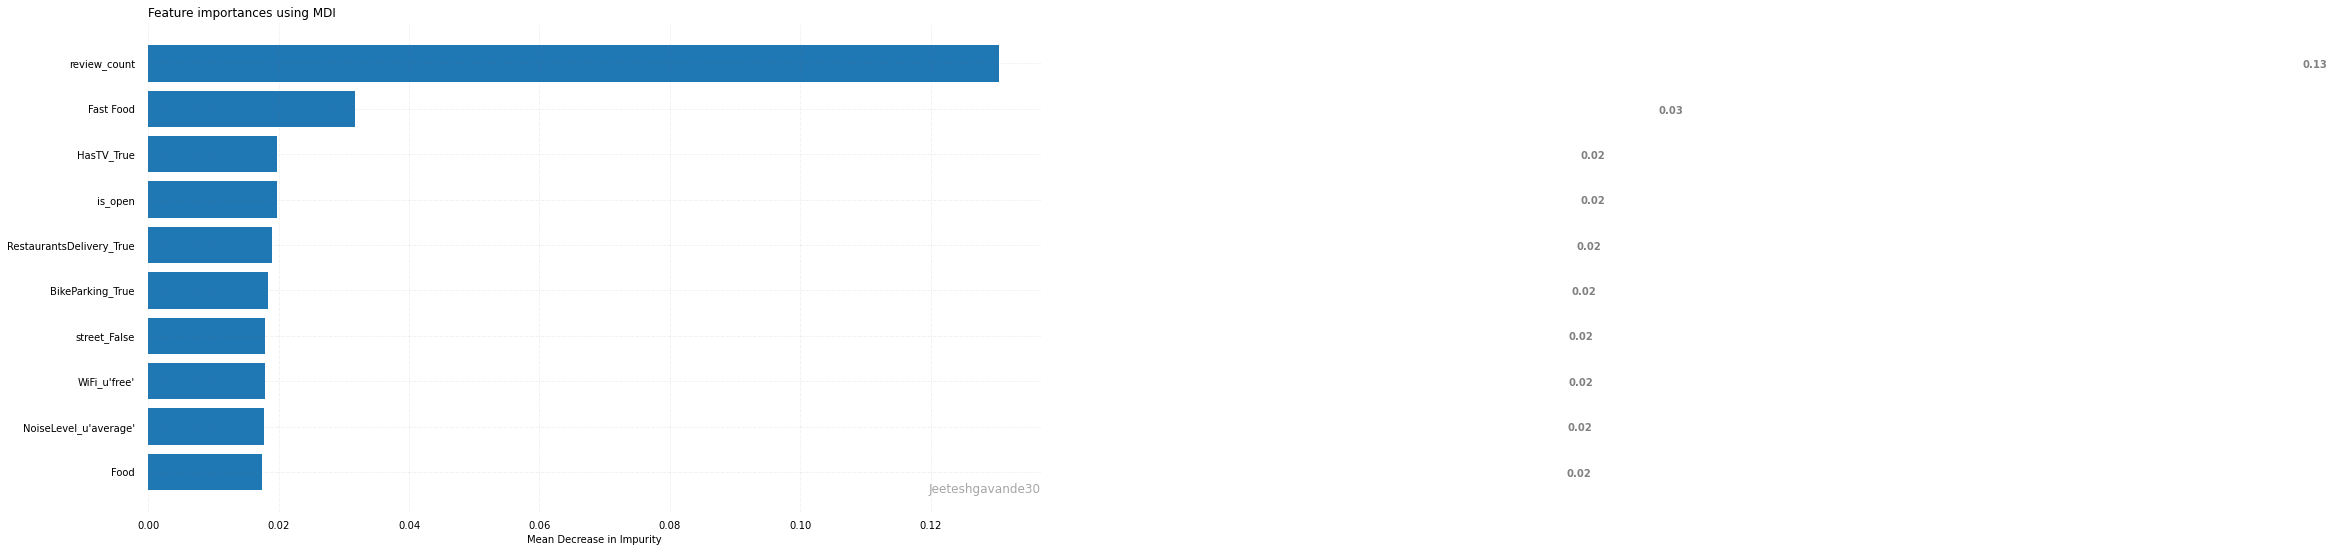

In [29]:
#Random Forests

random_grid = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# clf = RandomForestClassifier()
# clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = n_cpu-1)
# clf_random.fit(xTrain, yTrain)
# print(clf_random.best_params_)



# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                           cv = 3, n_jobs = n_cpu-1, verbose = 2)
# grid_search.fit(xTrain, yTrain)
# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))

clf = RandomForestClassifier()
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print(classification_report(yTest, yPred))

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=x.columns).nlargest(10)
print(forest_importances)

# Figure size
fig, ax = plt.subplots(figsize=(16,9))

# horizontal bar plot
ax.barh(forest_importances.index, forest_importances.values)

# remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)


# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 

# add Plot Title
ax.set_title('Feature importances using MDI', loc ='left', )

ax.set_xlabel("Mean Decrease in Impurity")
 
# Add Text watermark
fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

In [13]:
#pearson correlation
def pearson_corr(x, y):
    x['label'] = y
    xcorr = x.corr().abs()
    #setting up matplotlib
    f, ax = plt.subplots(figsize=(25,25))

    #generating mask
    mask = np.triu(np.ones_like(xcorr, dtype=bool))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(xcorr, annot=True, mask=mask, cmap=cmap)
    plt.savefig("Corr_Heatmap.png")

    #selecting best features
    bestfeatures = SelectKBest(k=5)
    fit=bestfeatures.fit(x, y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']

ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

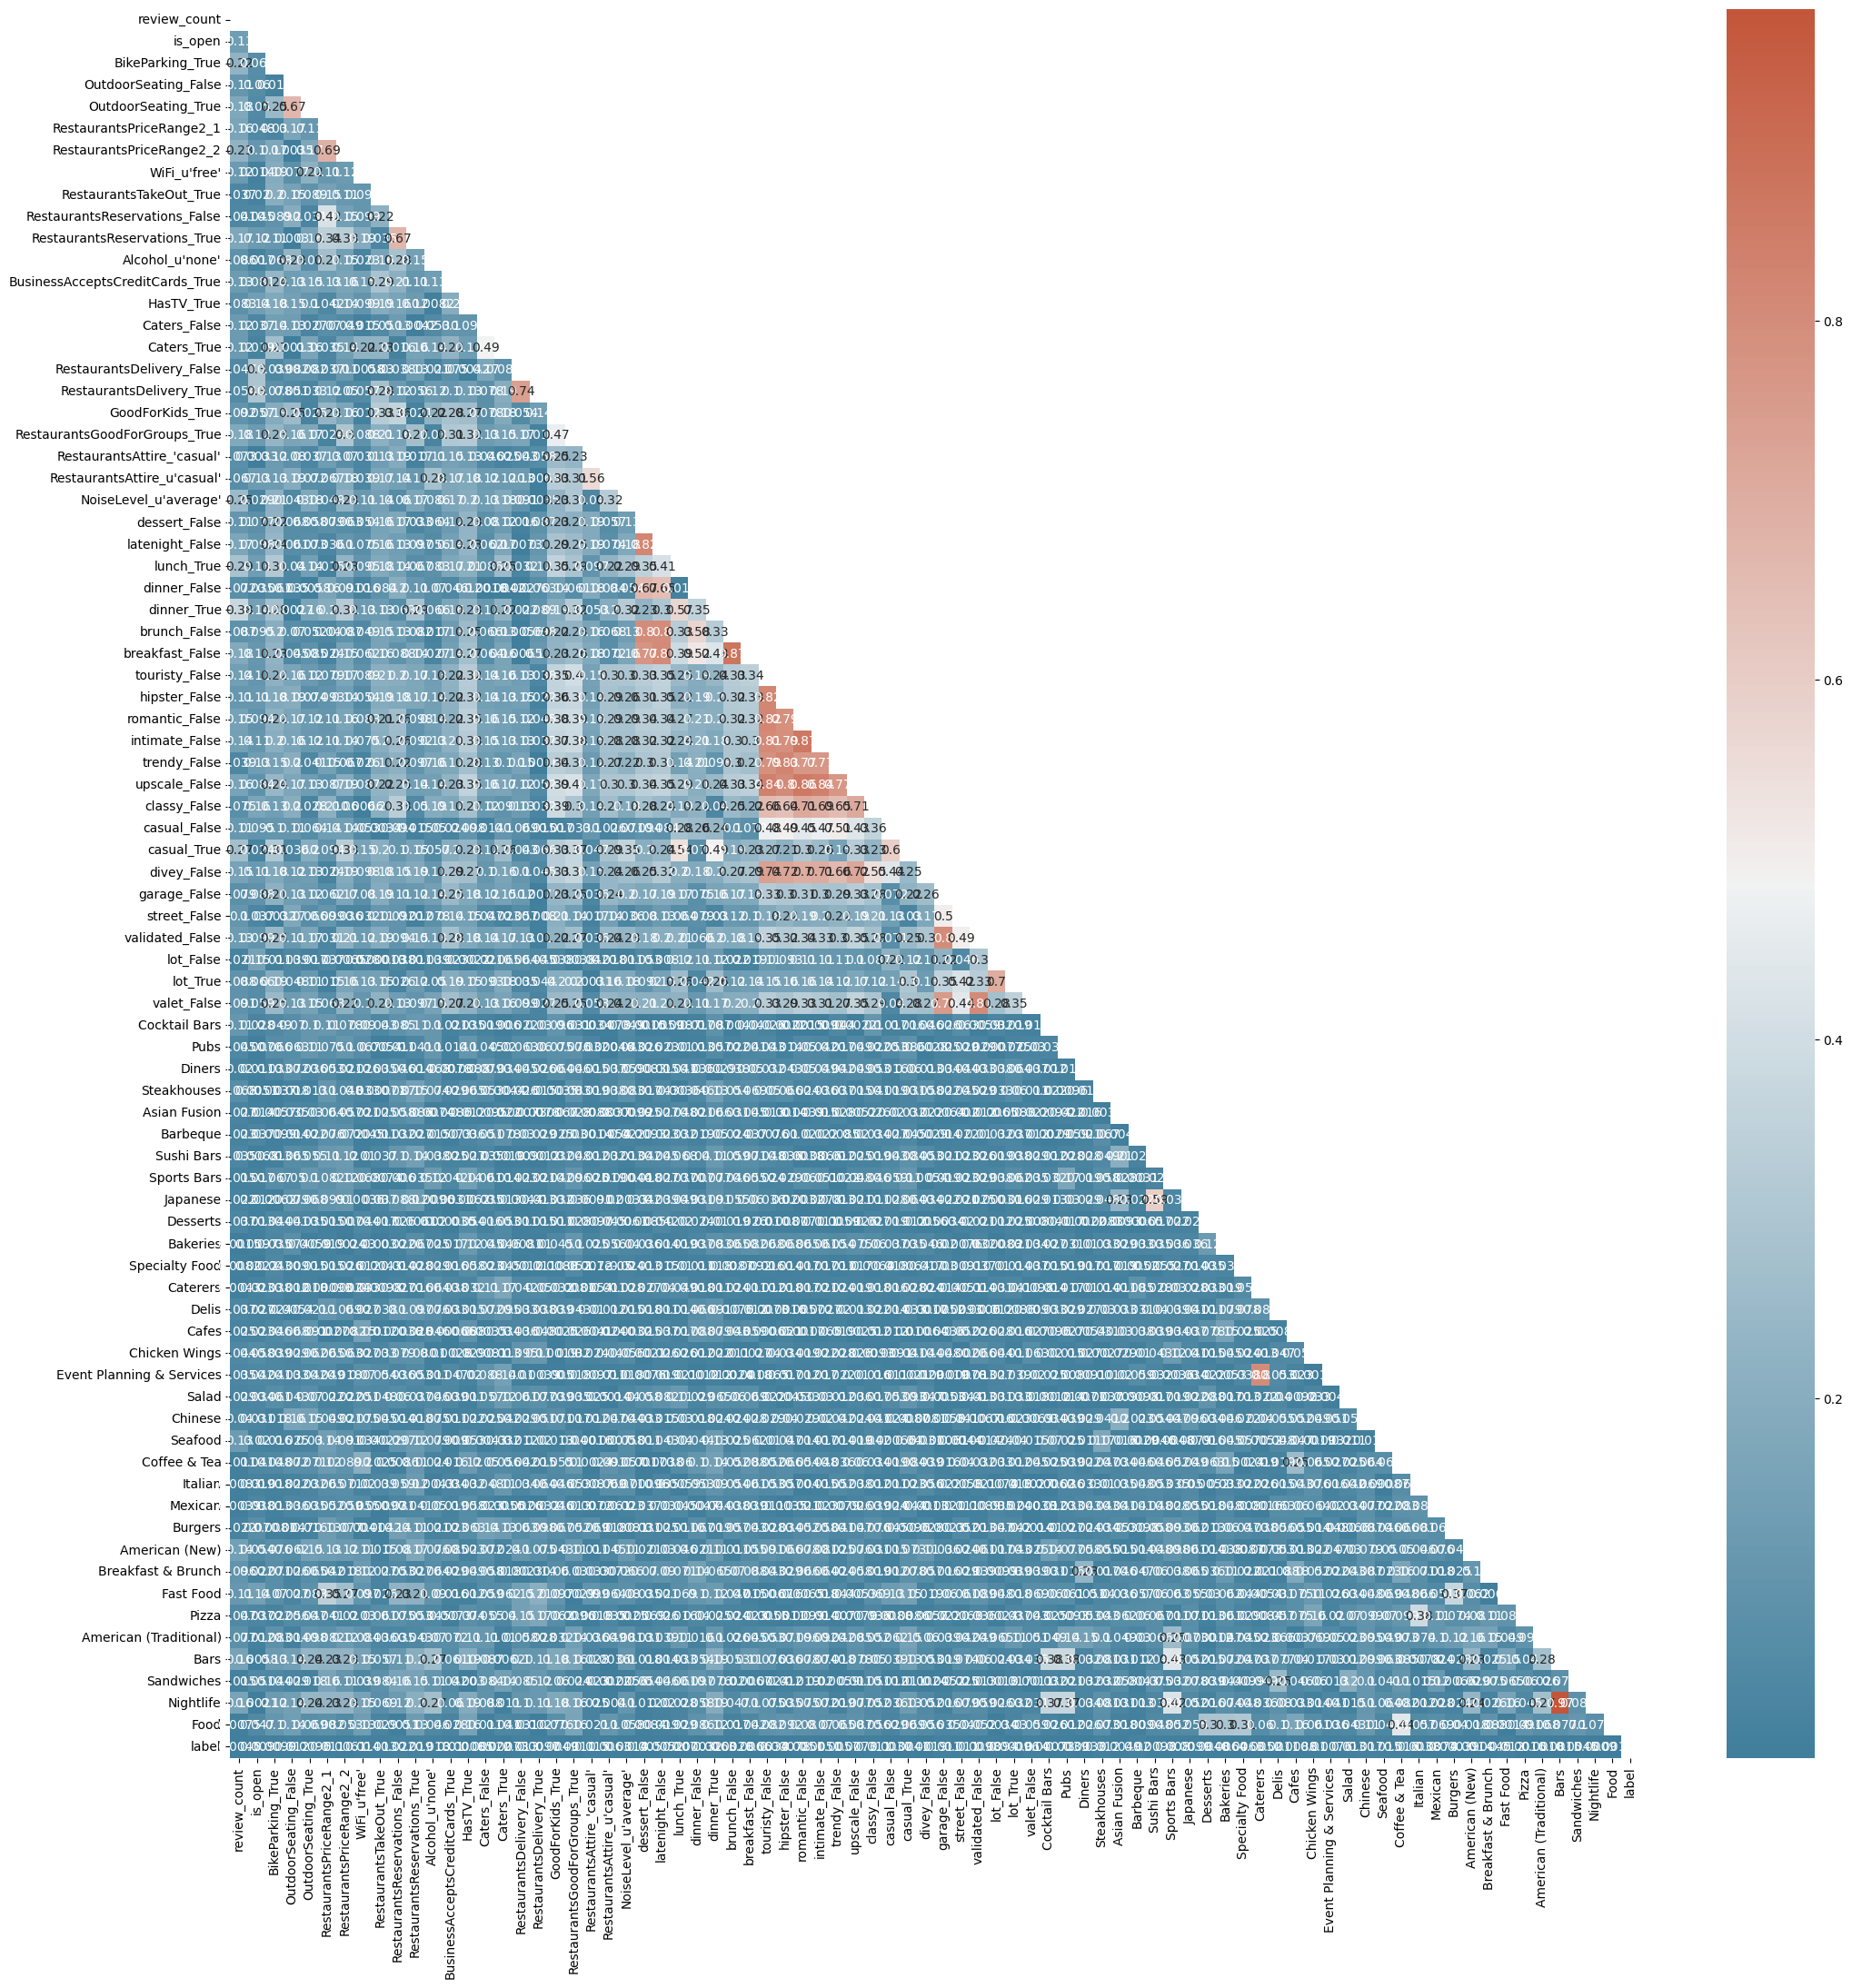

In [16]:
#pearson correlation

xTrainPear = pd.DataFrame(xTrain, columns=trainColumns)
pearson_corr(xTrainPear, yTrain)